# Project — Digital Image Processing

Tested different Segmentation methods to see which method is efficient in which domain.

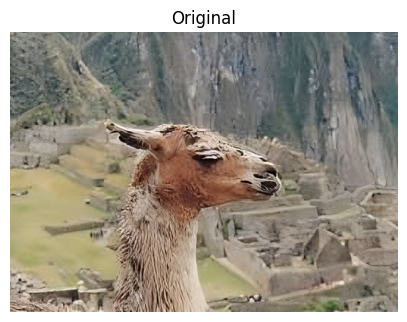

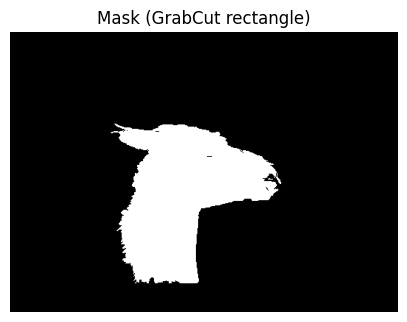

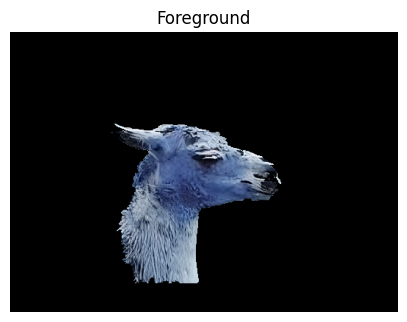

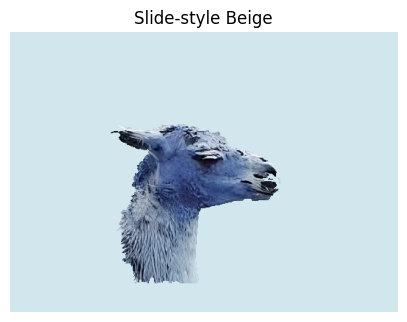

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(title, img):
    plt.figure(figsize=(5,5))
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def graphcut_rectangle(img, rect=None):
    H, W = img.shape[:2]

    if rect is None:
        # auto rectangle around center (works for object roughly centered)
        rect = (int(W*0.1), int(H*0.1), int(W*0.8), int(H*0.8))

    mask = np.zeros(img.shape[:2], np.uint8)
    bgModel = np.zeros((1,65), np.float64)
    fgModel = np.zeros((1,65), np.float64)

    cv2.grabCut(img, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)

    final_mask = np.where((mask==cv2.GC_FGD)|(mask==cv2.GC_PR_FGD), 1, 0).astype('uint8')
    return final_mask

def extract_foreground(img, mask):
    fg = img * mask[:,:,None]
    rgba = cv2.cvtColor(fg, cv2.COLOR_BGR2RGBA)
    rgba[:,:,3] = mask * 255
    return rgba

def place_on_beige(fg_rgba, color=(238,230,210)):
    H, W = fg_rgba.shape[:2]
    bg = np.full((H,W,3), color, dtype=np.uint8)
    a = fg_rgba[:,:,3]/255.0
    a = a[:,:,None]
    return (fg_rgba[:,:,:3] * a + bg*(1-a)).astype(np.uint8)

def run_pipeline(path):
    img = cv2.imread(path)

    # rectangle graphcut
    mask = graphcut_rectangle(img)

    cutout = extract_foreground(img, mask)
    pretty = place_on_beige(cutout)

    show("Original", img)
    show("Mask (GrabCut rectangle)", mask*255)
    show("Foreground", cutout)
    show("Slide-style Beige", pretty)

run_pipeline("sample.jpeg")
#run_pipeline("penguin.webp")

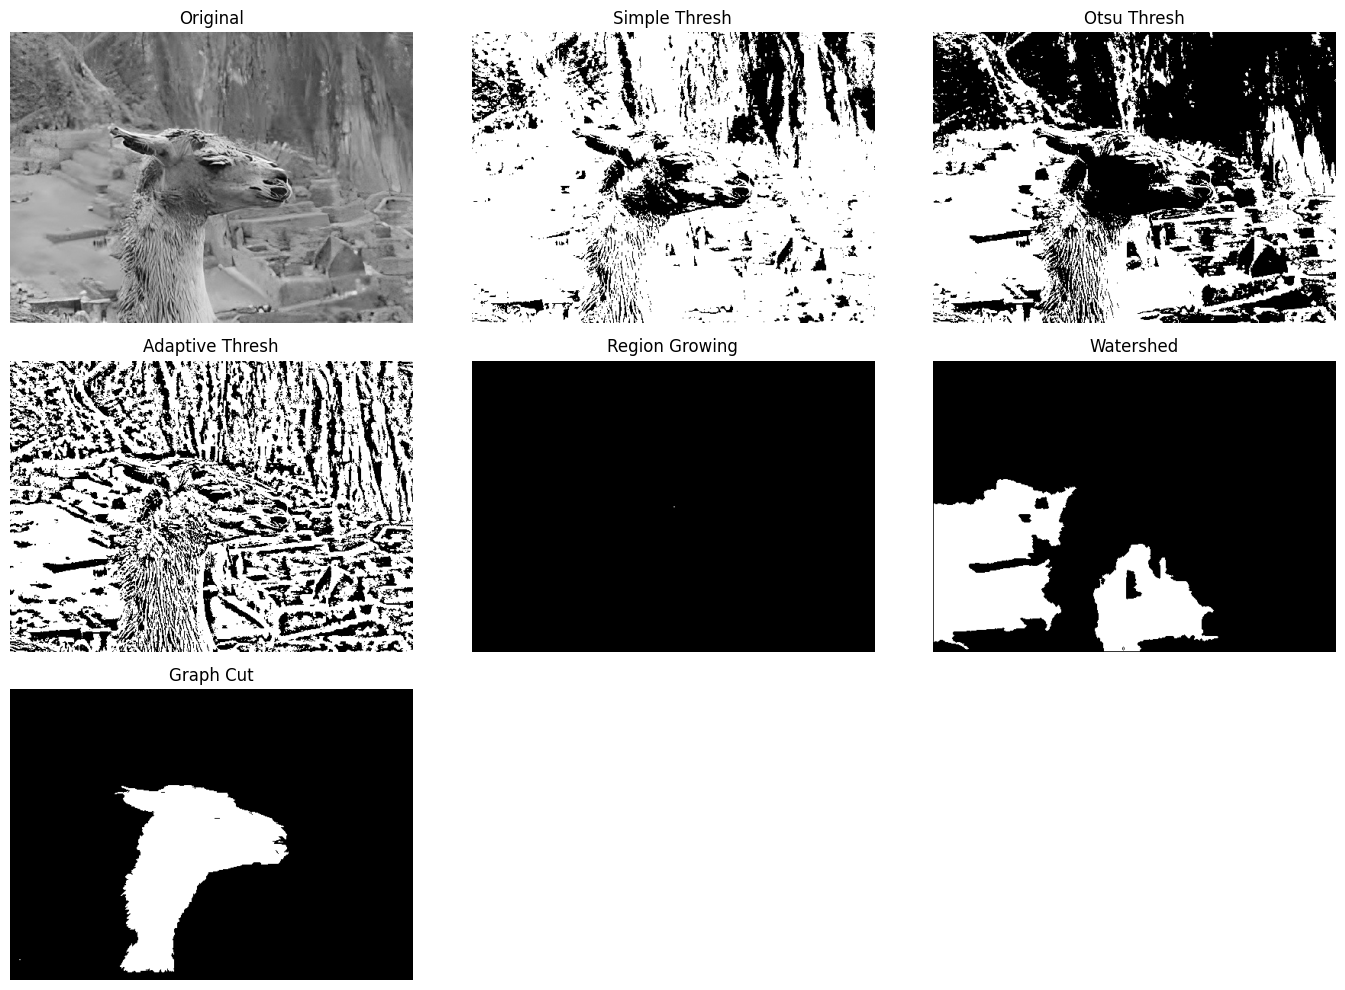

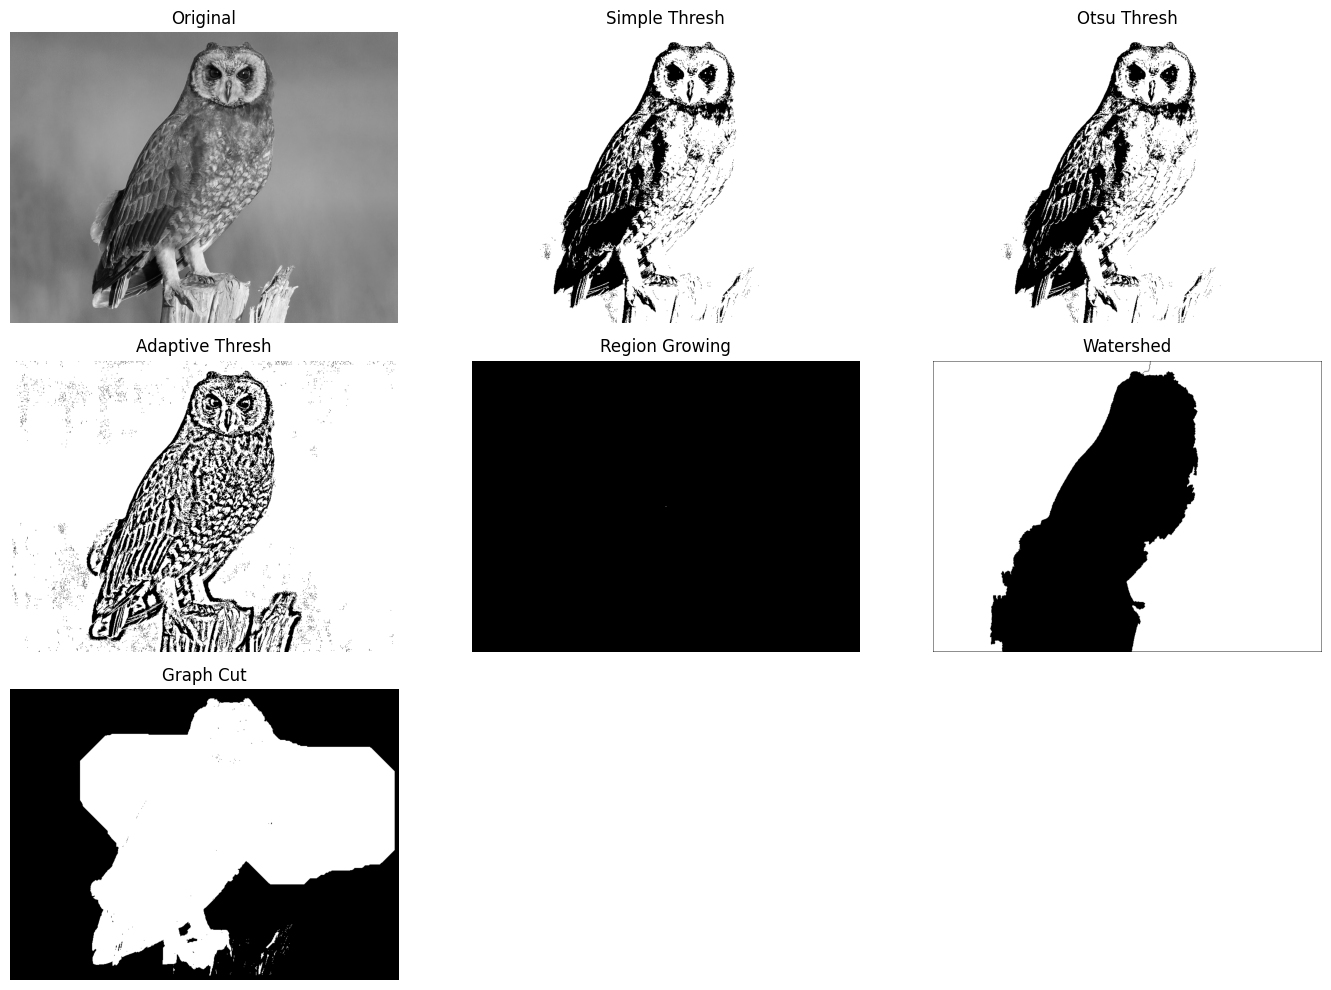

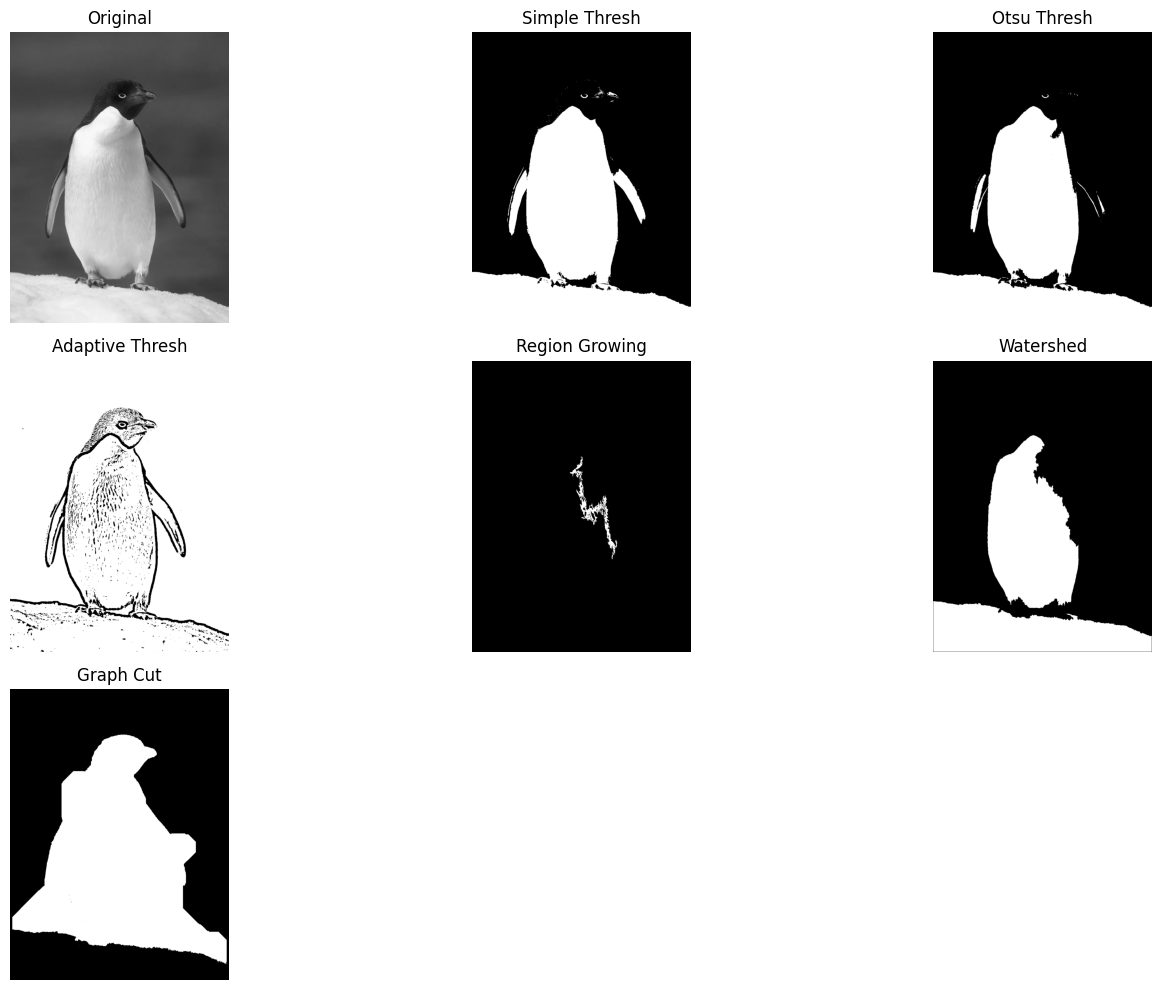

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#simple region growing
def region_growing(img, seed, thresh=5):
    h, w = img.shape
    segmented = np.zeros((h, w), np.uint8)
    stack = [seed]
    seed_val = img[seed]

    while stack:
        x, y = stack.pop()
        if segmented[x, y] == 1:
            continue

        if abs(int(img[x, y]) - int(seed_val)) < thresh:
            segmented[x, y] = 1
            for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                nx, ny = x+dx, y+dy
                if 0 <= nx < h and 0 <= ny < w:
                    stack.append((nx, ny))
    return segmented

#graph cut(grabcut)
def graph_cut(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgd = np.zeros((1,65), np.float64)
    fgd = np.zeros((1,65), np.float64)

    # rectangle around subject
    h, w = img.shape[:2]
    rect = (10, 10, w-20, h-20)

    cv2.grabCut(img, mask, rect, bgd, fgd, 5, cv2.GC_INIT_WITH_RECT)
    out = np.where((mask==2)|(mask==0), 0, 255).astype("uint8")
    return out

#watershed
def watershed_segmentation(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, 0.5*dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    img_ws = img.copy()
    markers = cv2.watershed(img_ws, markers)
    output = np.zeros_like(gray)
    output[markers > 1] = 255
    return output

#run
def run_all(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #global Threshold
    _, th_simple = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

    #otsu Threshold
    _, th_otsu = cv2.threshold(gray, 0, 255,
                               cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #adaptive Mean Threshold
    th_adapt = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, 21, 5
    )

    #region Growing
    seed = (gray.shape[0]//2, gray.shape[1]//2)
    rg = region_growing(gray, seed)

    #watershed
    ws = watershed_segmentation(img)

    #graph-Cut
    gc = graph_cut(img)

    titles = [
        "Original", "Simple Thresh", "Otsu Thresh", "Adaptive Thresh",
        "Region Growing", "Watershed", "Graph Cut"
    ]
    images = [gray, th_simple, th_otsu, th_adapt, rg*255, ws, gc]

    plt.figure(figsize=(14,10))
    for i in range(7):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_all("sample.jpeg")
    run_all("owl.jpg")
    run_all("penguin.webp")


C:\Users\reddy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\reddy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


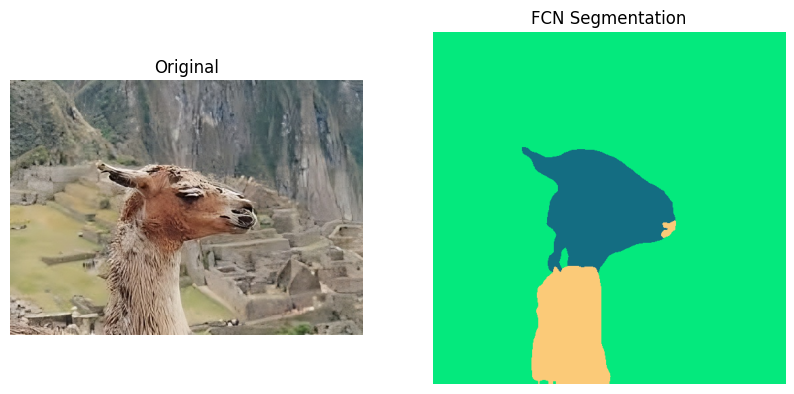

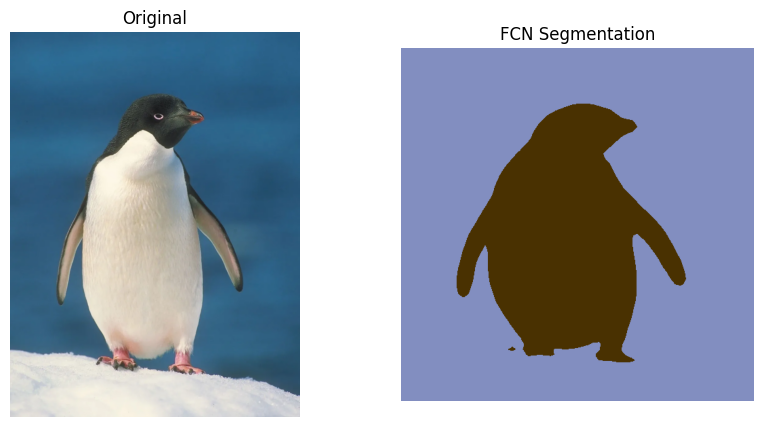

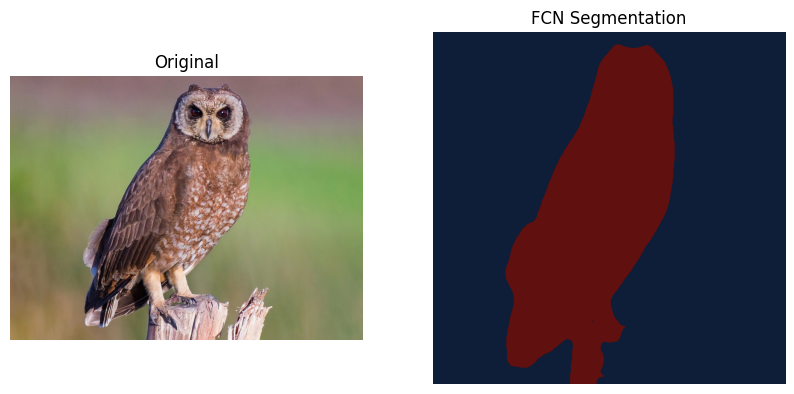

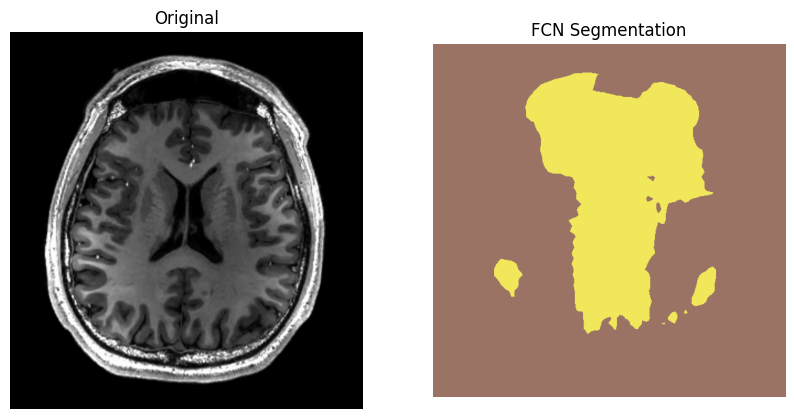

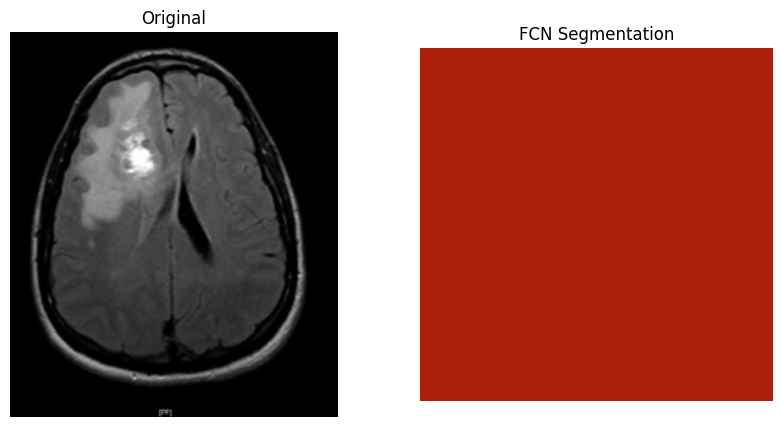

In [6]:
import torch
from torchvision import models, transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

#load pretrained FCN
def load_fcn():
    model = models.segmentation.deeplabv3_resnet101(pretrained=True)
    model.eval()
    return model

#preprocess img
def preprocess(img):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)

#decode FCN output
def decode_output(output):
    out = output['out'][0].detach().cpu().numpy()  # C x H x W
    seg = np.argmax(out, axis=0).astype(np.uint8)
    return seg

#color map
def color_map(seg):
    colors = np.random.randint(0, 255, size=(seg.max()+1, 3), dtype=np.uint8)
    h, w = seg.shape
    color_seg = np.zeros((h, w, 3), dtype=np.uint8)
    for label in range(seg.max()+1):
        color_seg[seg == label] = colors[label]
    return color_seg

#running fcn model
def run_fcn(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    model = load_fcn()
    inp = preprocess(img_rgb)

    with torch.no_grad():
        out = model(inp)

    seg = decode_output(out)
    seg_colored = color_map(seg)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(seg_colored)
    plt.title("FCN Segmentation")
    plt.axis("off")
    plt.show()


if __name__ == "__main__":
    run_fcn("sample.jpeg")
    run_fcn("penguin.webp")
    run_fcn("owl.jpg")
    run_fcn("mri.jpg")
    run_fcn("tumor.jpeg")


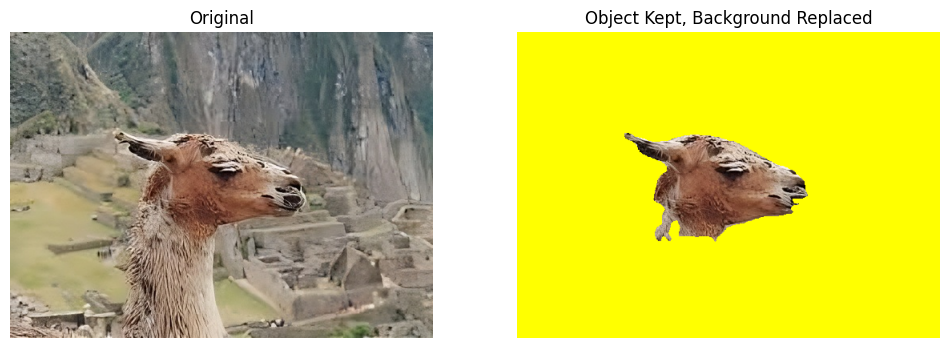

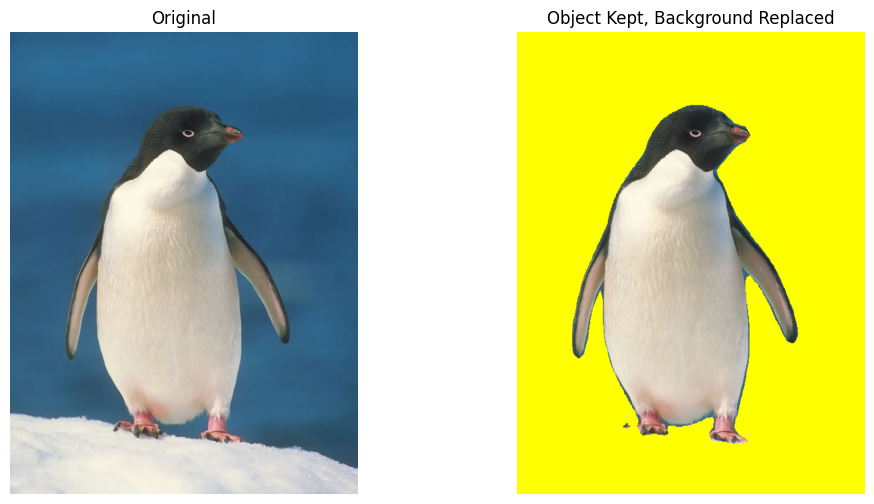

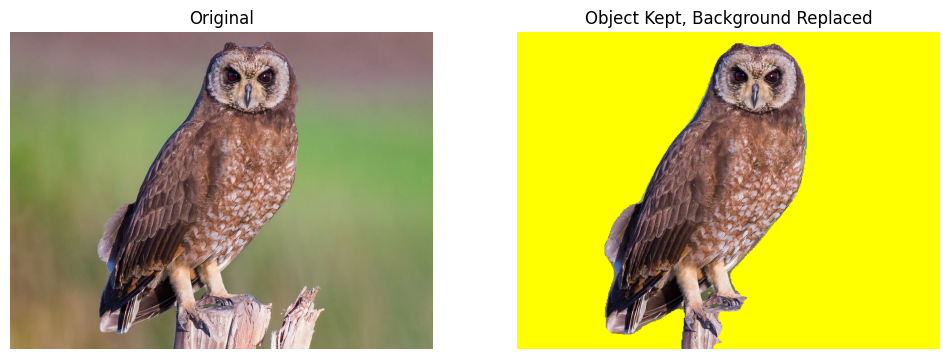

In [8]:
import torch
from torchvision import models, transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

#load segmentation model (deepLab= better)
def load_model():
    model = models.segmentation.deeplabv3_resnet101(pretrained=True)
    model.eval()
    return model

#preprocess img for model
def preprocess(img):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)

#decode model output + class label map
def decode_output(output):
    out = output['out'][0].detach().cpu().numpy()  # C x H x W
    seg = np.argmax(out, axis=0).astype(np.uint8)
    return seg

#keep object pixels, replace bg
def keep_object_replace_bg(img, seg, object_class, bg_color=(0, 255, 255)):
    mask = (seg == object_class).astype(np.uint8)

    output = img.copy()
    bg_rgb = bg_color[::-1]   # BGR → RGB

    #apply per-channel assignment safely
    output[mask == 0] = bg_rgb

    return output

def run_semantic_segmentation(img_path):
    #load + prep
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    model = load_model()
    inp = preprocess(img_rgb)

    # model inference
    with torch.no_grad():
        out = model(inp)

    seg = decode_output(out)

    #resize seg mask back to original resolution
    seg_resized = cv2.resize(seg, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

    #pick dominant class (remove background)
    unique, counts = np.unique(seg_resized, return_counts=True)
    class_counts = dict(zip(unique, counts))
    class_counts.pop(0, None)

    object_class = max(class_counts, key=class_counts.get)

    result = keep_object_replace_bg(img_rgb, seg_resized, object_class)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(result)
    plt.title("Object Kept, Background Replaced")
    plt.axis("off")

    plt.show()

if __name__ == "__main__":
    run_semantic_segmentation("sample.jpeg")
    run_semantic_segmentation("penguin.webp")
    run_semantic_segmentation("owl.jpg")
    #run_semantic_segmentation("mri.jpg")

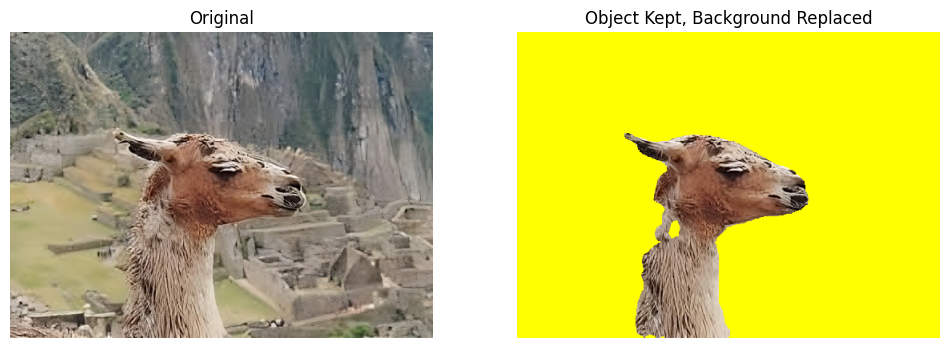

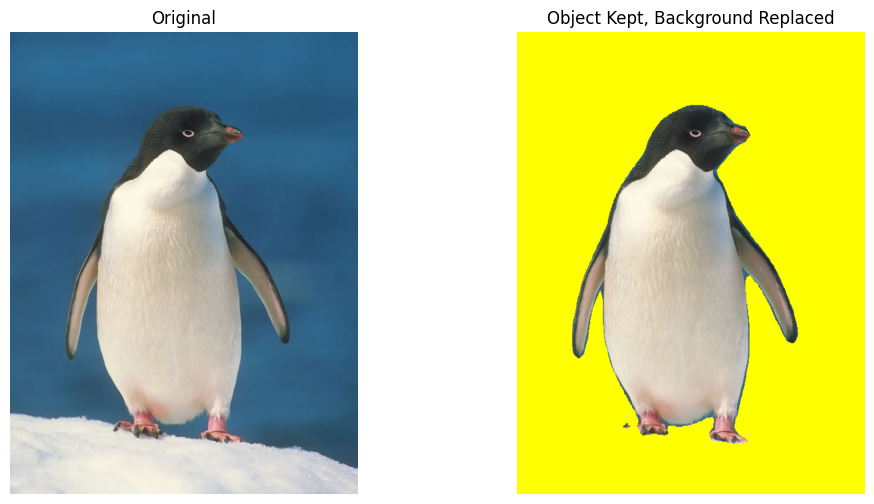

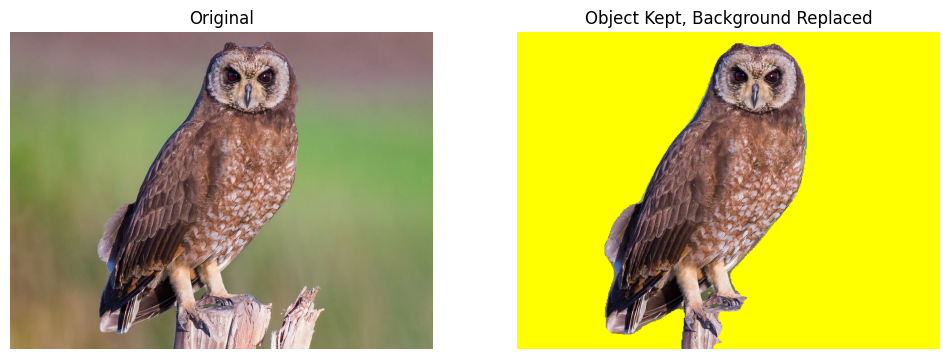

In [10]:
import torch
from torchvision import models, transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

#load segmentation model
def load_model():
    model = models.segmentation.deeplabv3_resnet101(pretrained=True)
    model.eval()
    return model

#preprocessing
def preprocess(img):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)

#decode model output + class label map
def decode_output(output):
    out = output['out'][0].detach().cpu().numpy()  # C × H × W
    seg = np.argmax(out, axis=0).astype(np.uint8)
    return seg

#apply binary: keep object, color bg
#img  : RGB original image
#mask : binary mask, 1 = object, 0 = background
#bg_color: background color (BGR)
def keep_object_replace_bg_mask(img, mask, bg_color=(255, 255, 0)):
    output = img.copy()
    bg_rgb = bg_color[::-1]  # convert BGR → RGB

    output[mask == 0] = bg_rgb
    return output

#main pipeline
def run_semantic_segmentation(img_path, bg_color=(255,255,0)):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    model = load_model()
    inp = preprocess(img_rgb)

    #model inference
    with torch.no_grad():
        out = model(inp)

    seg = decode_output(out)

    #resize seg mask back to original resolution
    seg_resized = cv2.resize(
        seg,
        (img_rgb.shape[1], img_rgb.shape[0]),
        interpolation=cv2.INTER_NEAREST
    )

    #combine all non-background classes into single object mask
    object_mask = (seg_resized != 0).astype(np.uint8)

    #final output
    result = keep_object_replace_bg_mask(img_rgb, object_mask, bg_color)

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(result)
    plt.title("Object Kept, Background Replaced")
    plt.axis("off")

    plt.show()

if __name__ == "__main__":
    run_semantic_segmentation("sample.jpeg", bg_color=(0,255,255))
    run_semantic_segmentation("penguin.webp", bg_color=(0,255,255))
    run_semantic_segmentation("owl.jpg", bg_color=(0,255,255))
    #run_semantic_segmentation("mri.jpg", bg_color=(0,255,255))


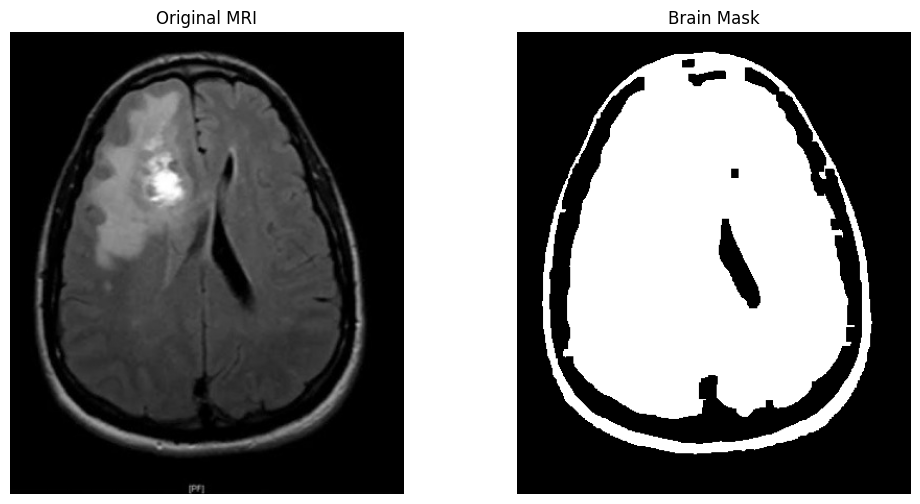

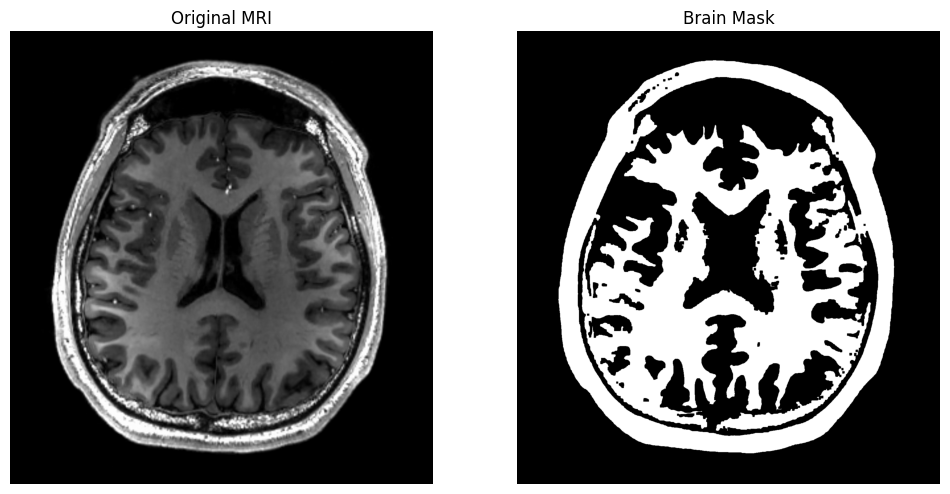

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1534, 1433), dtype=uint8)

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_brain(img_path):
    #load img
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    #img= 255 - img

    #otsu thresholding
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #MRI is white-brain on dark background → invert if needed
    if np.mean(img[thresh == 255]) < np.mean(img[thresh == 0]):
        thresh = cv2.bitwise_not(thresh)

    #morphological closing to fill gaps
    kernel = np.ones((7,7), np.uint8)
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    #largest connected component using OpenCV
    num_labels, labels = cv2.connectedComponents(closed)

    #find largest non-zero label
    largest_label = 1 + np.argmax([np.sum(labels == i) for i in range(1, num_labels)])

    mask = (labels == largest_label).astype(np.uint8) * 255

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title("Original MRI")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.title("Brain Mask")
    plt.axis("off")

    plt.show()

    return mask

segment_brain("tumor.jpeg")
segment_brain("mri.jpg")
#segment_brain("sample.jpeg")
#segment_brain("penguin.webp")
#segment_brain("owl.jpg")
